<a href="https://colab.research.google.com/github/FrancLis/Multivariate-Time-Series-Forecasting/blob/main/7a_RNN_Hyperparameter_Tuning_Talos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Hyperparameter Tuning

In this notebook is shown the code used for some experiments of Hyperparameter tuning made using the library Talos.

In [ ]:
!pip install talos
!pip install joblib

In [ ]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value = 0

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED'] = str(seed_value)

import numpy as np
import tensorflow as tf
import random as python_random

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(123)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
python_random.seed(123)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(1234)

import seaborn as sns
import pandas as pd
import talos as ta
from numpy import zeros, newaxis
from matplotlib import pyplot as plt
from joblib import dump, load
from keras.utils.vis_utils import plot_model
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, max_error, mean_absolute_error
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, GRU, Bidirectional, SimpleRNN, Conv1D, MaxPooling1D, Flatten

Load and read preprocessed data

In [ ]:
with open('Preprocessed_data_PG.npy', 'rb') as f:
    X_train = np.load(f)
    y_train = np.load(f)
    X_valid = np.load(f)
    y_valid = np.load(f)
    X_test = np.load(f)
    y_test = np.load(f)

print('All shapes are: (batch, time, features)')
print('X_train.shape:', X_train.shape, 'y_train.shape:', y_train.shape)
print('X_valid.shape:', X_valid.shape, 'y_valid.shape:', y_valid.shape)
print('X_test.shape:', X_test.shape, 'y_test.shape:', y_test.shape)

All shapes are: (batch, time, features)
X_train.shape: (10495, 20, 6) y_train.shape: (10495, 1)
X_valid.shape: (1293, 20, 6) y_valid.shape: (1293, 1)
X_test.shape: (1294, 20, 6) y_test.shape: (1294, 1)


Load scaler

In [ ]:
scaler = load('PowerTransformer_Close_PG.joblib')

It was verified through these lines of code that the two scales were equal

In [ ]:
# Those attributes are specific of MinMaxScaler. For other scalers they might change
# if (imported_scaler.scale_ == scaler.scale_).all() and (imported_scaler.data_max_ == scaler.data_max_).all() \
        # and (imported_scale.data_min_ == scaler.data_min_).all() and (imported_scale.data_range_ == scaler.data_range_).all():
   # print("Scalers are same")

It is necessary to import the shoe ladder then subsequently the new observations that the algorithm will predict in the future which will then be reused for the next prison prediction

In [ ]:
# from talos.utils import hidden_layers

The Hidden layers function has been imported from the Talos library but has been modified according to the needs of the project

In [ ]:
def network_shape_customized(params, last_neuron, network_type):
    '''Provides the ability to include network shape in experiments. If params
    dictionary for the round contains float value for params['shapes'] then
    a linear contraction towards the last_neuron value. The higher the value,
    the fewer layers it takes to reach lesser than last_neuron.
    Supports three inbuilt shapes 'brick', 'funnel', and 'triangle'.
    params : dict
         Scan() params for a single roundself.
    last_neuron : int
         Number of neurons on the output layer in the Keras model.
    '''
    import numpy as np
    from talos.utils.exceptions import TalosParamsError

    layers = params['hidden_layers']
    shape = params['shapes']
    # network_type == 0 --> SimpleRNN
    # network_type == 1 --> GRU
    # network_type == 2 --> LSTM
    # network_type == 3 --> CONV1D
    if network_type == 3:
        first_neuron = params['first_filter']
    else:
        first_neuron = params['first_neuron']

    out = []
    n = first_neuron

    # the case where hidden_layers is zero
    if layers == 0:
        return [0]

    # the cases where an angle is applied
    if isinstance(shape, float):

        for i in range(layers):

            n *= 1 - shape

            if n > last_neuron:
                out.append(int(n))
            else:
                out.append(last_neuron)

    # the case where a rectantular shape is used
    elif shape == 'brick':
        out = [first_neuron] * layers

    elif shape == 'funnel':
        for i in range(layers + 1):
            n -= int((first_neuron - last_neuron) / layers)
            out.append(n)
        out.pop(-1)

    elif shape == 'triangle':
        out = np.linspace(first_neuron,
                          last_neuron,
                          layers + 2,
                          dtype=int).tolist()

        out.pop(0)
        out.pop(-1)
        out.reverse()

    else:
        message = "'shapes' must be float or in ['funnel', 'brick', 'triangle']"
        raise TalosParamsError(message)

    return out


def hidden_layers_customized(model, params, last_neuron, network_type):
    '''HIDDEN LAYER Generator

    NOTE: 'shapes', 'first_neuron', 'dropout', and 'hidden_layers' need
    to be present in the params dictionary.

    Hidden layer generation for the cases where number
    of layers is used as a variable in the optimization process.
    Handles things in a way where any number of layers can be tried
    with matching hyperparameters.'''

    # check for the params that are required for hidden_layers

    from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, SimpleRNN, GRU, LSTM
    # from .network_shape import network_shape
    from talos.utils.exceptions import TalosParamsError

    if network_type != 3:
        required = ['shapes', 'first_neuron', 'hidden_layers',]
    else:
        required = ['shapes', 'first_filter', 'hidden_layers', 'kernel_size',]

    for param in required:
        if param not in params:
            message = "hidden_layers requires '" + param + "' in params"
            raise TalosParamsError(message)

    layer_neurons = network_shape_customized(params, last_neuron, network_type)
    # network_type == 0 --> SimpleRNN
    # network_type == 1 --> LSTM
    # network_type == 2 --> GRU
    # network_type == 3 --> CONV1D
    from keras.regularizers import l2
    if network_type == 0:
        for i in range(params['hidden_layers']):
            if params['hidden_layers'] == 0:
                model.add(SimpleRNN(layer_neurons[i], return_sequences=False,
                                    kernel_regularizer=keras.regularizers.l2(0.01),
                                    activity_regularizer=keras.regularizers.l2(0.1),))
            else:
                if i == params['hidden_layers'] - 1:
                    model.add(SimpleRNN(layer_neurons[i], return_sequences=False,
                                        kernel_regularizer=keras.regularizers.l2(0.01),
                                        activity_regularizer=keras.regularizers.l2(0.1),))
                else:
                    model.add(SimpleRNN(layer_neurons[i], return_sequences=True,
                                        kernel_regularizer=keras.regularizers.l2(0.01),
                                        activity_regularizer=keras.regularizers.l2(0.1),))
    elif network_type == 1:
        for i in range(params['hidden_layers']):
            if params['hidden_layers'] == 0:
                model.add(LSTM(layer_neurons[i], return_sequences=False, activation='elu'))
            else:
                if i == params['hidden_layers'] - 1:
                    model.add(LSTM(layer_neurons[i], return_sequences=False, activation='elu'))
                else:
                    model.add(LSTM(layer_neurons[i], return_sequences=True, activation='elu'))
    elif network_type == 2:
        for i in range(params['hidden_layers']):
            if params['hidden_layers'] == 0:
                model.add(GRU(layer_neurons[i], return_sequences=False, activation='relu'))
            else:
                if i == params['hidden_layers'] - 1:
                    model.add(GRU(layer_neurons[i], return_sequences=False, activation='relu'))
                else:
                    model.add(GRU(layer_neurons[i], return_sequences=True, activation='relu'))

    elif network_type == 3:
        for i in range(params['hidden_layers']):
            model.add(Conv1D(layer_neurons[i],
                             kernel_size=params.get('kernel_size'),
                             padding='same', activation='relu'))
            model.add(MaxPooling1D(pool_size=2, padding='same'))
            model.add(Dropout(0))
    else:
        message = "Model not supported"
        raise TalosParamsError(message)

#### Recurrent Neural Network (RNN)

In [ ]:
def rnn_fn(x_train, y_train, x_val, y_val, params):
	  # Step 1: reset the tensorflow backend session.
    tf.keras.backend.clear_session()
    # Step 2: Define the model with variable hyperparameters.
    # dropout = float(params['dropout'])
    lr = float(params['lr'])
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    hidden_layers_customized(model, params, y_train.shape[1], 0)
    model.add(Dropout(0))
    model.add(Dense(y_train.shape[1]))
    
    model.compile(
        loss='mse',
        # optimizer = 'Adam',
        optimizer = params['optimiz'](learning_rate=lr),
    )

    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    
    history = model.fit(
        x_train, y_train, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        verbose=0,
        validation_data=[x_val, y_val],
        callbacks=[stop_early], 
    )

    return history, model, 


para = {
    'batch_size': [32, 64], 
    'epochs': [27, 35, 42],  # 100, 200
    'shapes': ['brick', 'triangle', 'funnel'],               # <<< required
    'first_neuron': [32, 16],                      # <<< required
    'hidden_layers': [1, 2],                      # <<< required
     # 'dropout': [0],  # 0.25                     # <<< required
     'optimiz': [Adam],
     'lr': [0.001, 0.01, 0.1] 
}


In [ ]:
# Starting of Grid search
# Choose of model to tune
scan_results = ta.Scan(x=X_train,
                 y=y_train,
                 params=para,
                 model=rnn_fn,
                 experiment_name='Hyperparameter_Tuning',
                 x_val=X_valid,
                 y_val=y_valid,
                 # performance_target=['val_loss', 0.54, True],
                 disable_progress_bar=False, 
                 print_params=True)

  0%|          | 0/216 [00:00<?, ?it/s]

{'batch_size': 32, 'epochs': 27, 'first_neuron': 32, 'hidden_layers': 1, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


  0%|          | 1/216 [01:23<4:59:13, 83.50s/it]

{'batch_size': 32, 'epochs': 27, 'first_neuron': 32, 'hidden_layers': 1, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


  1%|          | 2/216 [02:05<3:31:05, 59.18s/it]

{'batch_size': 32, 'epochs': 27, 'first_neuron': 32, 'hidden_layers': 1, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


  1%|▏         | 3/216 [02:48<3:03:41, 51.74s/it]

{'batch_size': 32, 'epochs': 27, 'first_neuron': 32, 'hidden_layers': 1, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


  2%|▏         | 4/216 [03:30<2:49:29, 47.97s/it]

{'batch_size': 32, 'epochs': 27, 'first_neuron': 32, 'hidden_layers': 1, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


  2%|▏         | 5/216 [04:12<2:41:20, 45.88s/it]

{'batch_size': 32, 'epochs': 27, 'first_neuron': 32, 'hidden_layers': 1, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


  3%|▎         | 6/216 [04:48<2:28:50, 42.52s/it]

{'batch_size': 32, 'epochs': 27, 'first_neuron': 32, 'hidden_layers': 1, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


  3%|▎         | 7/216 [05:14<2:08:30, 36.89s/it]

{'batch_size': 32, 'epochs': 27, 'first_neuron': 32, 'hidden_layers': 1, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


  4%|▎         | 8/216 [05:56<2:13:45, 38.58s/it]

{'batch_size': 32, 'epochs': 27, 'first_neuron': 32, 'hidden_layers': 1, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


  4%|▍         | 9/216 [06:38<2:16:48, 39.66s/it]

{'batch_size': 32, 'epochs': 27, 'first_neuron': 32, 'hidden_layers': 2, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


  5%|▍         | 10/216 [07:55<2:55:47, 51.20s/it]

{'batch_size': 32, 'epochs': 27, 'first_neuron': 32, 'hidden_layers': 2, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


  5%|▌         | 11/216 [09:19<3:29:17, 61.26s/it]

{'batch_size': 32, 'epochs': 27, 'first_neuron': 32, 'hidden_layers': 2, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


  6%|▌         | 12/216 [10:31<3:39:44, 64.63s/it]

{'batch_size': 32, 'epochs': 27, 'first_neuron': 32, 'hidden_layers': 2, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


  6%|▌         | 13/216 [11:55<3:58:16, 70.42s/it]

{'batch_size': 32, 'epochs': 27, 'first_neuron': 32, 'hidden_layers': 2, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


  6%|▋         | 14/216 [13:19<4:10:38, 74.45s/it]

{'batch_size': 32, 'epochs': 27, 'first_neuron': 32, 'hidden_layers': 2, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


  7%|▋         | 15/216 [14:33<4:08:41, 74.24s/it]

{'batch_size': 32, 'epochs': 27, 'first_neuron': 32, 'hidden_layers': 2, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


  7%|▋         | 16/216 [15:20<3:40:59, 66.30s/it]

{'batch_size': 32, 'epochs': 27, 'first_neuron': 32, 'hidden_layers': 2, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


  8%|▊         | 17/216 [16:44<3:57:14, 71.53s/it]

{'batch_size': 32, 'epochs': 27, 'first_neuron': 32, 'hidden_layers': 2, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


  8%|▊         | 18/216 [18:08<4:08:09, 75.20s/it]

{'batch_size': 32, 'epochs': 27, 'first_neuron': 16, 'hidden_layers': 1, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


  9%|▉         | 19/216 [18:47<3:31:11, 64.32s/it]

{'batch_size': 32, 'epochs': 27, 'first_neuron': 16, 'hidden_layers': 1, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


  9%|▉         | 20/216 [19:25<3:04:31, 56.49s/it]

{'batch_size': 32, 'epochs': 27, 'first_neuron': 16, 'hidden_layers': 1, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


 10%|▉         | 21/216 [20:07<2:49:37, 52.19s/it]

{'batch_size': 32, 'epochs': 27, 'first_neuron': 16, 'hidden_layers': 1, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


 10%|█         | 22/216 [20:50<2:39:04, 49.20s/it]

{'batch_size': 32, 'epochs': 27, 'first_neuron': 16, 'hidden_layers': 1, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


 11%|█         | 23/216 [21:27<2:27:10, 45.75s/it]

{'batch_size': 32, 'epochs': 27, 'first_neuron': 16, 'hidden_layers': 1, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


 11%|█         | 24/216 [22:01<2:15:05, 42.22s/it]

{'batch_size': 32, 'epochs': 27, 'first_neuron': 16, 'hidden_layers': 1, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


 12%|█▏        | 25/216 [22:43<2:14:10, 42.15s/it]

{'batch_size': 32, 'epochs': 27, 'first_neuron': 16, 'hidden_layers': 1, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


 12%|█▏        | 26/216 [23:09<1:57:50, 37.21s/it]

{'batch_size': 32, 'epochs': 27, 'first_neuron': 16, 'hidden_layers': 1, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


 12%|█▎        | 27/216 [23:51<2:01:47, 38.66s/it]

{'batch_size': 32, 'epochs': 27, 'first_neuron': 16, 'hidden_layers': 2, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


 13%|█▎        | 28/216 [25:15<2:43:43, 52.25s/it]

{'batch_size': 32, 'epochs': 27, 'first_neuron': 16, 'hidden_layers': 2, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


 13%|█▎        | 29/216 [26:24<2:58:07, 57.15s/it]

{'batch_size': 32, 'epochs': 27, 'first_neuron': 16, 'hidden_layers': 2, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


 14%|█▍        | 30/216 [27:47<3:22:03, 65.18s/it]

{'batch_size': 32, 'epochs': 27, 'first_neuron': 16, 'hidden_layers': 2, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


 14%|█▍        | 31/216 [28:57<3:25:11, 66.55s/it]

{'batch_size': 32, 'epochs': 27, 'first_neuron': 16, 'hidden_layers': 2, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


 15%|█▍        | 32/216 [30:06<3:25:55, 67.15s/it]

{'batch_size': 32, 'epochs': 27, 'first_neuron': 16, 'hidden_layers': 2, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


 15%|█▌        | 33/216 [31:16<3:27:34, 68.06s/it]

{'batch_size': 32, 'epochs': 27, 'first_neuron': 16, 'hidden_layers': 2, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


 16%|█▌        | 34/216 [32:40<3:40:37, 72.73s/it]

{'batch_size': 32, 'epochs': 27, 'first_neuron': 16, 'hidden_layers': 2, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


 16%|█▌        | 35/216 [33:33<3:21:54, 66.93s/it]

{'batch_size': 32, 'epochs': 27, 'first_neuron': 16, 'hidden_layers': 2, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


 17%|█▋        | 36/216 [34:17<3:00:00, 60.00s/it]

{'batch_size': 32, 'epochs': 35, 'first_neuron': 32, 'hidden_layers': 1, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


 17%|█▋        | 37/216 [35:40<3:19:46, 66.96s/it]

{'batch_size': 32, 'epochs': 35, 'first_neuron': 32, 'hidden_layers': 1, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


 18%|█▊        | 38/216 [36:30<3:03:34, 61.88s/it]

{'batch_size': 32, 'epochs': 35, 'first_neuron': 32, 'hidden_layers': 1, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


 18%|█▊        | 39/216 [37:53<3:21:23, 68.27s/it]

{'batch_size': 32, 'epochs': 35, 'first_neuron': 32, 'hidden_layers': 1, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


 19%|█▊        | 40/216 [39:16<3:33:11, 72.68s/it]

{'batch_size': 32, 'epochs': 35, 'first_neuron': 32, 'hidden_layers': 1, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


 19%|█▉        | 41/216 [40:39<3:41:12, 75.84s/it]

{'batch_size': 32, 'epochs': 35, 'first_neuron': 32, 'hidden_layers': 1, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


 19%|█▉        | 42/216 [41:22<3:11:04, 65.89s/it]

{'batch_size': 32, 'epochs': 35, 'first_neuron': 32, 'hidden_layers': 1, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


 20%|█▉        | 43/216 [41:49<2:36:09, 54.16s/it]

{'batch_size': 32, 'epochs': 35, 'first_neuron': 32, 'hidden_layers': 1, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


 20%|██        | 44/216 [42:31<2:24:48, 50.51s/it]

{'batch_size': 32, 'epochs': 35, 'first_neuron': 32, 'hidden_layers': 1, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


 21%|██        | 45/216 [43:54<2:51:53, 60.31s/it]

{'batch_size': 32, 'epochs': 35, 'first_neuron': 32, 'hidden_layers': 2, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


 21%|██▏       | 46/216 [45:33<3:24:07, 72.04s/it]

{'batch_size': 32, 'epochs': 35, 'first_neuron': 32, 'hidden_layers': 2, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


 22%|██▏       | 47/216 [47:08<3:42:04, 78.84s/it]

{'batch_size': 32, 'epochs': 35, 'first_neuron': 32, 'hidden_layers': 2, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


 22%|██▏       | 48/216 [49:32<4:35:28, 98.38s/it]

{'batch_size': 32, 'epochs': 35, 'first_neuron': 32, 'hidden_layers': 2, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


 23%|██▎       | 49/216 [50:34<4:03:21, 87.44s/it]

{'batch_size': 32, 'epochs': 35, 'first_neuron': 32, 'hidden_layers': 2, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


 23%|██▎       | 50/216 [51:58<3:58:47, 86.31s/it]

{'batch_size': 32, 'epochs': 35, 'first_neuron': 32, 'hidden_layers': 2, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


 24%|██▎       | 51/216 [53:30<4:02:30, 88.18s/it]

{'batch_size': 32, 'epochs': 35, 'first_neuron': 32, 'hidden_layers': 2, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


 24%|██▍       | 52/216 [54:54<3:57:22, 86.85s/it]

{'batch_size': 32, 'epochs': 35, 'first_neuron': 32, 'hidden_layers': 2, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


 25%|██▍       | 53/216 [56:18<3:53:17, 85.87s/it]

{'batch_size': 32, 'epochs': 35, 'first_neuron': 32, 'hidden_layers': 2, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


 25%|██▌       | 54/216 [57:01<3:17:25, 73.12s/it]

{'batch_size': 32, 'epochs': 35, 'first_neuron': 16, 'hidden_layers': 1, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


 25%|██▌       | 55/216 [58:24<3:24:19, 76.14s/it]

{'batch_size': 32, 'epochs': 35, 'first_neuron': 16, 'hidden_layers': 1, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


 26%|██▌       | 56/216 [59:47<3:28:42, 78.27s/it]

{'batch_size': 32, 'epochs': 35, 'first_neuron': 16, 'hidden_layers': 1, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


 26%|██▋       | 57/216 [1:01:11<3:31:21, 79.76s/it]

{'batch_size': 32, 'epochs': 35, 'first_neuron': 16, 'hidden_layers': 1, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


 27%|██▋       | 58/216 [1:01:53<3:00:11, 68.43s/it]

{'batch_size': 32, 'epochs': 35, 'first_neuron': 16, 'hidden_layers': 1, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


 27%|██▋       | 59/216 [1:03:16<3:10:39, 72.86s/it]

{'batch_size': 32, 'epochs': 35, 'first_neuron': 16, 'hidden_layers': 1, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


 28%|██▊       | 60/216 [1:04:00<2:47:23, 64.38s/it]

{'batch_size': 32, 'epochs': 35, 'first_neuron': 16, 'hidden_layers': 1, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


 28%|██▊       | 61/216 [1:04:55<2:38:31, 61.37s/it]

{'batch_size': 32, 'epochs': 35, 'first_neuron': 16, 'hidden_layers': 1, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


 29%|██▊       | 62/216 [1:05:26<2:14:40, 52.47s/it]

{'batch_size': 32, 'epochs': 35, 'first_neuron': 16, 'hidden_layers': 1, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


 29%|██▉       | 63/216 [1:06:50<2:37:17, 61.68s/it]

{'batch_size': 32, 'epochs': 35, 'first_neuron': 16, 'hidden_layers': 2, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


 30%|██▉       | 64/216 [1:08:25<3:02:04, 71.87s/it]

{'batch_size': 32, 'epochs': 35, 'first_neuron': 16, 'hidden_layers': 2, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


 30%|███       | 65/216 [1:10:01<3:18:41, 78.95s/it]

{'batch_size': 32, 'epochs': 35, 'first_neuron': 16, 'hidden_layers': 2, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


 31%|███       | 66/216 [1:11:35<3:28:38, 83.46s/it]

{'batch_size': 32, 'epochs': 35, 'first_neuron': 16, 'hidden_layers': 2, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


 31%|███       | 67/216 [1:12:58<3:27:27, 83.54s/it]

{'batch_size': 32, 'epochs': 35, 'first_neuron': 16, 'hidden_layers': 2, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


 31%|███▏      | 68/216 [1:14:31<3:32:46, 86.26s/it]

{'batch_size': 32, 'epochs': 35, 'first_neuron': 16, 'hidden_layers': 2, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


 32%|███▏      | 69/216 [1:16:04<3:36:13, 88.25s/it]

{'batch_size': 32, 'epochs': 35, 'first_neuron': 16, 'hidden_layers': 2, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


 32%|███▏      | 70/216 [1:17:28<3:31:24, 86.88s/it]

{'batch_size': 32, 'epochs': 35, 'first_neuron': 16, 'hidden_layers': 2, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


 33%|███▎      | 71/216 [1:18:16<3:01:59, 75.31s/it]

{'batch_size': 32, 'epochs': 35, 'first_neuron': 16, 'hidden_layers': 2, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


 33%|███▎      | 72/216 [1:19:02<2:39:42, 66.54s/it]

{'batch_size': 32, 'epochs': 42, 'first_neuron': 32, 'hidden_layers': 1, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


 34%|███▍      | 73/216 [1:20:25<2:50:31, 71.55s/it]

{'batch_size': 32, 'epochs': 42, 'first_neuron': 32, 'hidden_layers': 1, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


 34%|███▍      | 74/216 [1:21:26<2:42:01, 68.46s/it]

{'batch_size': 32, 'epochs': 42, 'first_neuron': 32, 'hidden_layers': 1, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


 35%|███▍      | 75/216 [1:22:50<2:51:16, 72.88s/it]

{'batch_size': 32, 'epochs': 42, 'first_neuron': 32, 'hidden_layers': 1, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


 35%|███▌      | 76/216 [1:23:35<2:31:06, 64.76s/it]

{'batch_size': 32, 'epochs': 42, 'first_neuron': 32, 'hidden_layers': 1, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


 36%|███▌      | 77/216 [1:24:58<2:42:41, 70.23s/it]

{'batch_size': 32, 'epochs': 42, 'first_neuron': 32, 'hidden_layers': 1, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


 36%|███▌      | 78/216 [1:25:51<2:29:27, 64.98s/it]

{'batch_size': 32, 'epochs': 42, 'first_neuron': 32, 'hidden_layers': 1, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


 37%|███▋      | 79/216 [1:26:33<2:12:37, 58.09s/it]

{'batch_size': 32, 'epochs': 42, 'first_neuron': 32, 'hidden_layers': 1, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


 37%|███▋      | 80/216 [1:27:15<2:00:42, 53.26s/it]

{'batch_size': 32, 'epochs': 42, 'first_neuron': 32, 'hidden_layers': 1, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


 38%|███▊      | 81/216 [1:28:08<1:59:44, 53.22s/it]

{'batch_size': 32, 'epochs': 42, 'first_neuron': 32, 'hidden_layers': 2, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


 38%|███▊      | 82/216 [1:30:10<2:44:57, 73.86s/it]

{'batch_size': 32, 'epochs': 42, 'first_neuron': 32, 'hidden_layers': 2, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


 38%|███▊      | 83/216 [1:32:05<3:10:46, 86.06s/it]

{'batch_size': 32, 'epochs': 42, 'first_neuron': 32, 'hidden_layers': 2, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


 39%|███▉      | 84/216 [1:34:29<3:47:32, 103.43s/it]

{'batch_size': 32, 'epochs': 42, 'first_neuron': 32, 'hidden_layers': 2, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


 39%|███▉      | 85/216 [1:35:53<3:32:57, 97.53s/it] 

{'batch_size': 32, 'epochs': 42, 'first_neuron': 32, 'hidden_layers': 2, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


 40%|███▉      | 86/216 [1:38:16<4:01:25, 111.43s/it]

{'batch_size': 32, 'epochs': 42, 'first_neuron': 32, 'hidden_layers': 2, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


 40%|████      | 87/216 [1:39:40<3:41:43, 103.13s/it]

{'batch_size': 32, 'epochs': 42, 'first_neuron': 32, 'hidden_layers': 2, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


 41%|████      | 88/216 [1:40:29<3:05:00, 86.72s/it] 

{'batch_size': 32, 'epochs': 42, 'first_neuron': 32, 'hidden_layers': 2, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


 41%|████      | 89/216 [1:41:13<2:36:51, 74.11s/it]

{'batch_size': 32, 'epochs': 42, 'first_neuron': 32, 'hidden_layers': 2, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


 42%|████▏     | 90/216 [1:41:57<2:16:10, 64.84s/it]

{'batch_size': 32, 'epochs': 42, 'first_neuron': 16, 'hidden_layers': 1, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


 42%|████▏     | 91/216 [1:42:57<2:12:35, 63.65s/it]

{'batch_size': 32, 'epochs': 42, 'first_neuron': 16, 'hidden_layers': 1, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


 43%|████▎     | 92/216 [1:43:57<2:08:58, 62.41s/it]

{'batch_size': 32, 'epochs': 42, 'first_neuron': 16, 'hidden_layers': 1, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


 43%|████▎     | 93/216 [1:44:50<2:02:21, 59.69s/it]

{'batch_size': 32, 'epochs': 42, 'first_neuron': 16, 'hidden_layers': 1, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


 44%|████▎     | 94/216 [1:45:44<1:57:31, 57.80s/it]

{'batch_size': 32, 'epochs': 42, 'first_neuron': 16, 'hidden_layers': 1, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


 44%|████▍     | 95/216 [1:46:38<1:54:13, 56.64s/it]

{'batch_size': 32, 'epochs': 42, 'first_neuron': 16, 'hidden_layers': 1, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


 44%|████▍     | 96/216 [1:48:01<2:09:10, 64.59s/it]

{'batch_size': 32, 'epochs': 42, 'first_neuron': 16, 'hidden_layers': 1, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


 45%|████▍     | 97/216 [1:48:30<1:46:49, 53.86s/it]

{'batch_size': 32, 'epochs': 42, 'first_neuron': 16, 'hidden_layers': 1, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


 45%|████▌     | 98/216 [1:48:55<1:28:53, 45.20s/it]

{'batch_size': 32, 'epochs': 42, 'first_neuron': 16, 'hidden_layers': 1, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


 46%|████▌     | 99/216 [1:49:29<1:21:55, 42.01s/it]

{'batch_size': 32, 'epochs': 42, 'first_neuron': 16, 'hidden_layers': 2, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


 46%|████▋     | 100/216 [1:51:24<2:03:19, 63.79s/it]

{'batch_size': 32, 'epochs': 42, 'first_neuron': 16, 'hidden_layers': 2, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


 47%|████▋     | 101/216 [1:53:48<2:48:21, 87.84s/it]

{'batch_size': 32, 'epochs': 42, 'first_neuron': 16, 'hidden_layers': 2, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


 47%|████▋     | 102/216 [1:55:39<3:00:33, 95.03s/it]

{'batch_size': 32, 'epochs': 42, 'first_neuron': 16, 'hidden_layers': 2, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


 48%|████▊     | 103/216 [1:57:06<2:54:11, 92.49s/it]

{'batch_size': 32, 'epochs': 42, 'first_neuron': 16, 'hidden_layers': 2, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


 48%|████▊     | 104/216 [1:58:46<2:56:53, 94.77s/it]

{'batch_size': 32, 'epochs': 42, 'first_neuron': 16, 'hidden_layers': 2, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


 49%|████▊     | 105/216 [2:00:10<2:49:03, 91.38s/it]

{'batch_size': 32, 'epochs': 42, 'first_neuron': 16, 'hidden_layers': 2, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


 49%|████▉     | 106/216 [2:01:33<2:43:18, 89.08s/it]

{'batch_size': 32, 'epochs': 42, 'first_neuron': 16, 'hidden_layers': 2, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


 50%|████▉     | 107/216 [2:02:57<2:38:53, 87.46s/it]

{'batch_size': 32, 'epochs': 42, 'first_neuron': 16, 'hidden_layers': 2, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


 50%|█████     | 108/216 [2:03:40<2:13:39, 74.25s/it]

{'batch_size': 64, 'epochs': 27, 'first_neuron': 32, 'hidden_layers': 1, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


 50%|█████     | 109/216 [2:04:05<1:45:55, 59.40s/it]

{'batch_size': 64, 'epochs': 27, 'first_neuron': 32, 'hidden_layers': 1, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


 51%|█████     | 110/216 [2:04:27<1:25:05, 48.17s/it]

{'batch_size': 64, 'epochs': 27, 'first_neuron': 32, 'hidden_layers': 1, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


 51%|█████▏    | 111/216 [2:04:46<1:08:54, 39.38s/it]

{'batch_size': 64, 'epochs': 27, 'first_neuron': 32, 'hidden_layers': 1, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


 52%|█████▏    | 112/216 [2:05:12<1:01:08, 35.27s/it]

{'batch_size': 64, 'epochs': 27, 'first_neuron': 32, 'hidden_layers': 1, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


 52%|█████▏    | 113/216 [2:05:33<53:34, 31.21s/it]  

{'batch_size': 64, 'epochs': 27, 'first_neuron': 32, 'hidden_layers': 1, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


 53%|█████▎    | 114/216 [2:05:51<46:19, 27.25s/it]

{'batch_size': 64, 'epochs': 27, 'first_neuron': 32, 'hidden_layers': 1, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


 53%|█████▎    | 115/216 [2:06:06<39:28, 23.45s/it]

{'batch_size': 64, 'epochs': 27, 'first_neuron': 32, 'hidden_layers': 1, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


 54%|█████▎    | 116/216 [2:06:19<33:57, 20.37s/it]

{'batch_size': 64, 'epochs': 27, 'first_neuron': 32, 'hidden_layers': 1, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


 54%|█████▍    | 117/216 [2:06:41<34:16, 20.77s/it]

{'batch_size': 64, 'epochs': 27, 'first_neuron': 32, 'hidden_layers': 2, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


 55%|█████▍    | 118/216 [2:07:25<45:18, 27.74s/it]

{'batch_size': 64, 'epochs': 27, 'first_neuron': 32, 'hidden_layers': 2, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


 55%|█████▌    | 119/216 [2:08:08<52:06, 32.24s/it]

{'batch_size': 64, 'epochs': 27, 'first_neuron': 32, 'hidden_layers': 2, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


 56%|█████▌    | 120/216 [2:08:51<56:47, 35.49s/it]

{'batch_size': 64, 'epochs': 27, 'first_neuron': 32, 'hidden_layers': 2, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


 56%|█████▌    | 121/216 [2:09:23<54:44, 34.57s/it]

{'batch_size': 64, 'epochs': 27, 'first_neuron': 32, 'hidden_layers': 2, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


 56%|█████▋    | 122/216 [2:10:04<57:05, 36.45s/it]

{'batch_size': 64, 'epochs': 27, 'first_neuron': 32, 'hidden_layers': 2, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


 57%|█████▋    | 123/216 [2:10:47<59:26, 38.35s/it]

{'batch_size': 64, 'epochs': 27, 'first_neuron': 32, 'hidden_layers': 2, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


 57%|█████▋    | 124/216 [2:11:30<1:00:52, 39.70s/it]

{'batch_size': 64, 'epochs': 27, 'first_neuron': 32, 'hidden_layers': 2, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


 58%|█████▊    | 125/216 [2:12:01<56:12, 37.06s/it]  

{'batch_size': 64, 'epochs': 27, 'first_neuron': 32, 'hidden_layers': 2, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


 58%|█████▊    | 126/216 [2:12:43<58:10, 38.78s/it]

{'batch_size': 64, 'epochs': 27, 'first_neuron': 16, 'hidden_layers': 1, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


 59%|█████▉    | 127/216 [2:13:26<59:05, 39.84s/it]

{'batch_size': 64, 'epochs': 27, 'first_neuron': 16, 'hidden_layers': 1, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


 59%|█████▉    | 128/216 [2:13:47<50:23, 34.36s/it]

{'batch_size': 64, 'epochs': 27, 'first_neuron': 16, 'hidden_layers': 1, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


 60%|█████▉    | 129/216 [2:14:06<43:12, 29.80s/it]

{'batch_size': 64, 'epochs': 27, 'first_neuron': 16, 'hidden_layers': 1, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


 60%|██████    | 130/216 [2:14:28<39:12, 27.36s/it]

{'batch_size': 64, 'epochs': 27, 'first_neuron': 16, 'hidden_layers': 1, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


 61%|██████    | 131/216 [2:14:50<36:22, 25.67s/it]

{'batch_size': 64, 'epochs': 27, 'first_neuron': 16, 'hidden_layers': 1, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


 61%|██████    | 132/216 [2:15:12<34:19, 24.51s/it]

{'batch_size': 64, 'epochs': 27, 'first_neuron': 16, 'hidden_layers': 1, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


 62%|██████▏   | 133/216 [2:15:33<32:40, 23.63s/it]

{'batch_size': 64, 'epochs': 27, 'first_neuron': 16, 'hidden_layers': 1, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


 62%|██████▏   | 134/216 [2:15:55<31:25, 23.00s/it]

{'batch_size': 64, 'epochs': 27, 'first_neuron': 16, 'hidden_layers': 1, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


 62%|██████▎   | 135/216 [2:16:13<29:09, 21.60s/it]

{'batch_size': 64, 'epochs': 27, 'first_neuron': 16, 'hidden_layers': 2, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


 63%|██████▎   | 136/216 [2:16:52<35:53, 26.92s/it]

{'batch_size': 64, 'epochs': 27, 'first_neuron': 16, 'hidden_layers': 2, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


 63%|██████▎   | 137/216 [2:17:32<40:23, 30.68s/it]

{'batch_size': 64, 'epochs': 27, 'first_neuron': 16, 'hidden_layers': 2, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


 64%|██████▍   | 138/216 [2:18:15<44:40, 34.37s/it]

{'batch_size': 64, 'epochs': 27, 'first_neuron': 16, 'hidden_layers': 2, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


 64%|██████▍   | 139/216 [2:18:54<46:01, 35.86s/it]

{'batch_size': 64, 'epochs': 27, 'first_neuron': 16, 'hidden_layers': 2, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


 65%|██████▍   | 140/216 [2:19:34<46:47, 36.94s/it]

{'batch_size': 64, 'epochs': 27, 'first_neuron': 16, 'hidden_layers': 2, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


 65%|██████▌   | 141/216 [2:20:12<46:42, 37.37s/it]

{'batch_size': 64, 'epochs': 27, 'first_neuron': 16, 'hidden_layers': 2, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


 66%|██████▌   | 142/216 [2:20:55<48:05, 38.99s/it]

{'batch_size': 64, 'epochs': 27, 'first_neuron': 16, 'hidden_layers': 2, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


 66%|██████▌   | 143/216 [2:21:24<43:51, 36.05s/it]

{'batch_size': 64, 'epochs': 27, 'first_neuron': 16, 'hidden_layers': 2, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


 67%|██████▋   | 144/216 [2:21:57<42:06, 35.09s/it]

{'batch_size': 64, 'epochs': 35, 'first_neuron': 32, 'hidden_layers': 1, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


 67%|██████▋   | 145/216 [2:22:39<44:04, 37.25s/it]

{'batch_size': 64, 'epochs': 35, 'first_neuron': 32, 'hidden_layers': 1, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


 68%|██████▊   | 146/216 [2:23:05<39:39, 33.99s/it]

{'batch_size': 64, 'epochs': 35, 'first_neuron': 32, 'hidden_layers': 1, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


 68%|██████▊   | 147/216 [2:23:48<41:55, 36.46s/it]

{'batch_size': 64, 'epochs': 35, 'first_neuron': 32, 'hidden_layers': 1, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


 69%|██████▊   | 148/216 [2:24:30<43:17, 38.20s/it]

{'batch_size': 64, 'epochs': 35, 'first_neuron': 32, 'hidden_layers': 1, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


 69%|██████▉   | 149/216 [2:24:57<39:04, 34.99s/it]

{'batch_size': 64, 'epochs': 35, 'first_neuron': 32, 'hidden_layers': 1, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


 69%|██████▉   | 150/216 [2:25:20<34:27, 31.33s/it]

{'batch_size': 64, 'epochs': 35, 'first_neuron': 32, 'hidden_layers': 1, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


 70%|██████▉   | 151/216 [2:25:35<28:42, 26.51s/it]

{'batch_size': 64, 'epochs': 35, 'first_neuron': 32, 'hidden_layers': 1, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


 70%|███████   | 152/216 [2:25:57<26:40, 25.01s/it]

{'batch_size': 64, 'epochs': 35, 'first_neuron': 32, 'hidden_layers': 1, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


 71%|███████   | 153/216 [2:26:39<31:41, 30.19s/it]

{'batch_size': 64, 'epochs': 35, 'first_neuron': 32, 'hidden_layers': 2, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


 71%|███████▏  | 154/216 [2:28:03<47:51, 46.31s/it]

{'batch_size': 64, 'epochs': 35, 'first_neuron': 32, 'hidden_layers': 2, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


 72%|███████▏  | 155/216 [2:28:59<50:02, 49.23s/it]

{'batch_size': 64, 'epochs': 35, 'first_neuron': 32, 'hidden_layers': 2, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


 72%|███████▏  | 156/216 [2:29:54<50:51, 50.86s/it]

{'batch_size': 64, 'epochs': 35, 'first_neuron': 32, 'hidden_layers': 2, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


 73%|███████▎  | 157/216 [2:30:33<46:25, 47.21s/it]

{'batch_size': 64, 'epochs': 35, 'first_neuron': 32, 'hidden_layers': 2, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


 73%|███████▎  | 158/216 [2:31:24<46:51, 48.47s/it]

{'batch_size': 64, 'epochs': 35, 'first_neuron': 32, 'hidden_layers': 2, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


 74%|███████▎  | 159/216 [2:32:14<46:22, 48.81s/it]

{'batch_size': 64, 'epochs': 35, 'first_neuron': 32, 'hidden_layers': 2, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


 74%|███████▍  | 160/216 [2:32:43<39:59, 42.85s/it]

{'batch_size': 64, 'epochs': 35, 'first_neuron': 32, 'hidden_layers': 2, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


 75%|███████▍  | 161/216 [2:33:25<39:15, 42.83s/it]

{'batch_size': 64, 'epochs': 35, 'first_neuron': 32, 'hidden_layers': 2, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


 75%|███████▌  | 162/216 [2:34:08<38:30, 42.79s/it]

{'batch_size': 64, 'epochs': 35, 'first_neuron': 16, 'hidden_layers': 1, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


 75%|███████▌  | 163/216 [2:34:50<37:40, 42.64s/it]

{'batch_size': 64, 'epochs': 35, 'first_neuron': 16, 'hidden_layers': 1, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


 76%|███████▌  | 164/216 [2:35:16<32:37, 37.65s/it]

{'batch_size': 64, 'epochs': 35, 'first_neuron': 16, 'hidden_layers': 1, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


 76%|███████▋  | 165/216 [2:35:59<33:09, 39.02s/it]

{'batch_size': 64, 'epochs': 35, 'first_neuron': 16, 'hidden_layers': 1, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


 77%|███████▋  | 166/216 [2:36:41<33:21, 40.03s/it]

{'batch_size': 64, 'epochs': 35, 'first_neuron': 16, 'hidden_layers': 1, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


 77%|███████▋  | 167/216 [2:37:07<29:20, 35.93s/it]

{'batch_size': 64, 'epochs': 35, 'first_neuron': 16, 'hidden_layers': 1, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


 78%|███████▊  | 168/216 [2:37:19<22:57, 28.70s/it]

{'batch_size': 64, 'epochs': 35, 'first_neuron': 16, 'hidden_layers': 1, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


 78%|███████▊  | 169/216 [2:37:35<19:22, 24.73s/it]

{'batch_size': 64, 'epochs': 35, 'first_neuron': 16, 'hidden_layers': 1, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


 79%|███████▊  | 170/216 [2:37:48<16:18, 21.27s/it]

{'batch_size': 64, 'epochs': 35, 'first_neuron': 16, 'hidden_layers': 1, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


 79%|███████▉  | 171/216 [2:38:30<20:39, 27.55s/it]

{'batch_size': 64, 'epochs': 35, 'first_neuron': 16, 'hidden_layers': 2, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


 80%|███████▉  | 172/216 [2:39:21<25:18, 34.50s/it]

{'batch_size': 64, 'epochs': 35, 'first_neuron': 16, 'hidden_layers': 2, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


 80%|████████  | 173/216 [2:40:45<35:21, 49.33s/it]

{'batch_size': 64, 'epochs': 35, 'first_neuron': 16, 'hidden_layers': 2, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


 81%|████████  | 174/216 [2:41:33<34:25, 49.18s/it]

{'batch_size': 64, 'epochs': 35, 'first_neuron': 16, 'hidden_layers': 2, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


 81%|████████  | 175/216 [2:42:14<31:52, 46.64s/it]

{'batch_size': 64, 'epochs': 35, 'first_neuron': 16, 'hidden_layers': 2, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


 81%|████████▏ | 176/216 [2:43:38<38:34, 57.86s/it]

{'batch_size': 64, 'epochs': 35, 'first_neuron': 16, 'hidden_layers': 2, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


 82%|████████▏ | 177/216 [2:44:29<36:08, 55.60s/it]

{'batch_size': 64, 'epochs': 35, 'first_neuron': 16, 'hidden_layers': 2, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


 82%|████████▏ | 178/216 [2:44:55<29:43, 46.94s/it]

{'batch_size': 64, 'epochs': 35, 'first_neuron': 16, 'hidden_layers': 2, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


 83%|████████▎ | 179/216 [2:45:19<24:44, 40.13s/it]

{'batch_size': 64, 'epochs': 35, 'first_neuron': 16, 'hidden_layers': 2, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


 83%|████████▎ | 180/216 [2:46:02<24:33, 40.94s/it]

{'batch_size': 64, 'epochs': 42, 'first_neuron': 32, 'hidden_layers': 1, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


 84%|████████▍ | 181/216 [2:47:27<31:28, 53.97s/it]

{'batch_size': 64, 'epochs': 42, 'first_neuron': 32, 'hidden_layers': 1, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


 84%|████████▍ | 182/216 [2:47:59<26:57, 47.58s/it]

{'batch_size': 64, 'epochs': 42, 'first_neuron': 32, 'hidden_layers': 1, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


 85%|████████▍ | 183/216 [2:48:42<25:20, 46.09s/it]

{'batch_size': 64, 'epochs': 42, 'first_neuron': 32, 'hidden_layers': 1, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


 85%|████████▌ | 184/216 [2:49:16<22:36, 42.38s/it]

{'batch_size': 64, 'epochs': 42, 'first_neuron': 32, 'hidden_layers': 1, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


 86%|████████▌ | 185/216 [2:49:49<20:31, 39.71s/it]

{'batch_size': 64, 'epochs': 42, 'first_neuron': 32, 'hidden_layers': 1, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


 86%|████████▌ | 186/216 [2:50:31<20:13, 40.47s/it]

{'batch_size': 64, 'epochs': 42, 'first_neuron': 32, 'hidden_layers': 1, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


 87%|████████▋ | 187/216 [2:50:53<16:48, 34.79s/it]

{'batch_size': 64, 'epochs': 42, 'first_neuron': 32, 'hidden_layers': 1, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


 87%|████████▋ | 188/216 [2:51:06<13:14, 28.38s/it]

{'batch_size': 64, 'epochs': 42, 'first_neuron': 32, 'hidden_layers': 1, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


 88%|████████▊ | 189/216 [2:51:49<14:38, 32.54s/it]

{'batch_size': 64, 'epochs': 42, 'first_neuron': 32, 'hidden_layers': 2, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


 88%|████████▊ | 190/216 [2:53:00<19:11, 44.27s/it]

{'batch_size': 64, 'epochs': 42, 'first_neuron': 32, 'hidden_layers': 2, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


 88%|████████▊ | 191/216 [2:54:03<20:43, 49.74s/it]

{'batch_size': 64, 'epochs': 42, 'first_neuron': 32, 'hidden_layers': 2, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


 89%|████████▉ | 192/216 [2:55:27<24:00, 60.03s/it]

{'batch_size': 64, 'epochs': 42, 'first_neuron': 32, 'hidden_layers': 2, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


 89%|████████▉ | 193/216 [2:56:15<21:36, 56.37s/it]

{'batch_size': 64, 'epochs': 42, 'first_neuron': 32, 'hidden_layers': 2, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


 90%|████████▉ | 194/216 [2:57:38<23:40, 64.58s/it]

{'batch_size': 64, 'epochs': 42, 'first_neuron': 32, 'hidden_layers': 2, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


 90%|█████████ | 195/216 [2:58:21<20:18, 58.02s/it]

{'batch_size': 64, 'epochs': 42, 'first_neuron': 32, 'hidden_layers': 2, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


 91%|█████████ | 196/216 [2:58:49<16:20, 49.04s/it]

{'batch_size': 64, 'epochs': 42, 'first_neuron': 32, 'hidden_layers': 2, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


 91%|█████████ | 197/216 [2:59:15<13:17, 42.00s/it]

{'batch_size': 64, 'epochs': 42, 'first_neuron': 32, 'hidden_layers': 2, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


 92%|█████████▏| 198/216 [2:59:39<11:01, 36.77s/it]

{'batch_size': 64, 'epochs': 42, 'first_neuron': 16, 'hidden_layers': 1, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


 92%|█████████▏| 199/216 [3:00:22<10:53, 38.41s/it]

{'batch_size': 64, 'epochs': 42, 'first_neuron': 16, 'hidden_layers': 1, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


 93%|█████████▎| 200/216 [3:00:55<09:48, 36.81s/it]

{'batch_size': 64, 'epochs': 42, 'first_neuron': 16, 'hidden_layers': 1, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


 93%|█████████▎| 201/216 [3:01:23<08:35, 34.36s/it]

{'batch_size': 64, 'epochs': 42, 'first_neuron': 16, 'hidden_layers': 1, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


 94%|█████████▎| 202/216 [3:02:05<08:33, 36.67s/it]

{'batch_size': 64, 'epochs': 42, 'first_neuron': 16, 'hidden_layers': 1, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


 94%|█████████▍| 203/216 [3:02:48<08:18, 38.33s/it]

{'batch_size': 64, 'epochs': 42, 'first_neuron': 16, 'hidden_layers': 1, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


 94%|█████████▍| 204/216 [3:03:30<07:54, 39.50s/it]

{'batch_size': 64, 'epochs': 42, 'first_neuron': 16, 'hidden_layers': 1, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


 95%|█████████▍| 205/216 [3:03:51<06:15, 34.12s/it]

{'batch_size': 64, 'epochs': 42, 'first_neuron': 16, 'hidden_layers': 1, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


 95%|█████████▌| 206/216 [3:04:13<05:03, 30.34s/it]

{'batch_size': 64, 'epochs': 42, 'first_neuron': 16, 'hidden_layers': 1, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


 96%|█████████▌| 207/216 [3:04:40<04:23, 29.30s/it]

{'batch_size': 64, 'epochs': 42, 'first_neuron': 16, 'hidden_layers': 2, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


 96%|█████████▋| 208/216 [3:05:40<05:08, 38.57s/it]

{'batch_size': 64, 'epochs': 42, 'first_neuron': 16, 'hidden_layers': 2, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


 97%|█████████▋| 209/216 [3:06:39<05:12, 44.70s/it]

{'batch_size': 64, 'epochs': 42, 'first_neuron': 16, 'hidden_layers': 2, 'lr': 0.001, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


 97%|█████████▋| 210/216 [3:08:03<05:38, 56.48s/it]

{'batch_size': 64, 'epochs': 42, 'first_neuron': 16, 'hidden_layers': 2, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


 98%|█████████▊| 211/216 [3:08:45<04:21, 52.23s/it]

{'batch_size': 64, 'epochs': 42, 'first_neuron': 16, 'hidden_layers': 2, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


 98%|█████████▊| 212/216 [3:09:48<03:41, 55.43s/it]

{'batch_size': 64, 'epochs': 42, 'first_neuron': 16, 'hidden_layers': 2, 'lr': 0.01, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


 99%|█████████▊| 213/216 [3:10:43<02:45, 55.27s/it]

{'batch_size': 64, 'epochs': 42, 'first_neuron': 16, 'hidden_layers': 2, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'brick'}


 99%|█████████▉| 214/216 [3:11:26<01:43, 51.53s/it]

{'batch_size': 64, 'epochs': 42, 'first_neuron': 16, 'hidden_layers': 2, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'triangle'}


100%|█████████▉| 215/216 [3:11:52<00:43, 43.89s/it]

{'batch_size': 64, 'epochs': 42, 'first_neuron': 16, 'hidden_layers': 2, 'lr': 0.1, 'optimiz': <class 'keras.optimizer_v2.adam.Adam'>, 'shapes': 'funnel'}


100%|██████████| 216/216 [3:12:35<00:00, 53.50s/it]


## 4. Model Selection

In [ ]:
r = ta.Reporting('/content/Hyperparameter_Tuning/042222142000.csv')

# returns the results dataframe
r.data.sort_values(by=['val_loss'], ascending=True).iloc[:10, :]

,round_epochs,loss,val_loss,batch_size,epochs,first_neuron,hidden_layers,lr,optimiz,shapes
77,42,0.001226,0.001831,32,42,32,1,0.010,<class 'keras.optimizer_v2.adam.Adam'>,funnel
72,42,0.001180,0.001960,32,42,32,1,0.001,<class 'keras.optimizer_v2.adam.Adam'>,brick
73,42,0.001191,0.002083,32,42,32,1,0.001,<class 'keras.optimizer_v2.adam.Adam'>,triangle
95,42,0.001358,0.002164,32,42,16,1,0.010,<class 'keras.optimizer_v2.adam.Adam'>,funnel
41,35,0.001524,0.002188,32,35,32,1,0.010,<class 'keras.optimizer_v2.adam.Adam'>,funnel
36,35,0.001241,0.002193,32,35,32,1,0.001,<class 'keras.optimizer_v2.adam.Adam'>,brick
59,35,0.001541,0.002244,32,35,16,1,0.010,<class 'keras.optimizer_v2.adam.Adam'>,funnel
90,42,0.001430,0.002545,32,42,16,1,0.001,<class 'keras.optimizer_v2.adam.Adam'>,brick
22,27,0.001638,0.002558,32,27,16,1,0.010,<class 'keras.optimizer_v2.adam.Adam'>,triangle
185,42,0.001525,0.002600,64,42,32,1,0.010,<class 'keras.optimizer_v2.adam.Adam'>,funnel


In [ ]:
# get correlation for hyperparameters against a metric
r.correlate('val_loss', ['loss', 'val_loss', 'round_epochs',])

batch_size      -0.065611
epochs           0.030575
first_neuron     0.137293
hidden_layers    0.276610
lr               0.455850
Name: val_loss, dtype: float64

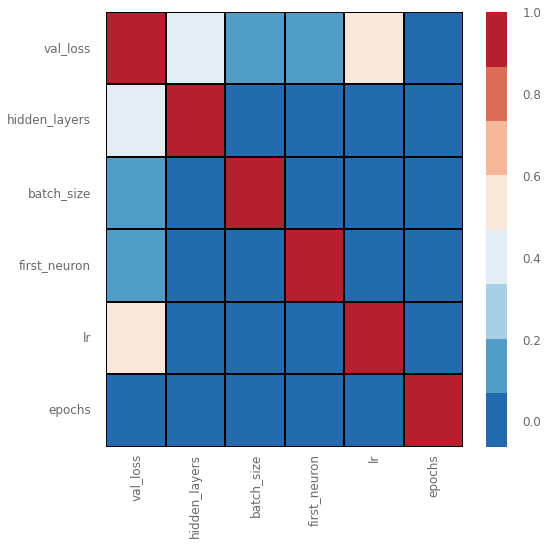

In [ ]:
# get a correlation plot for hyperparameters against a metric 
r.plot_corr('val_loss', ['loss', 'val_loss', 'round_epochs',])
# plt.savefig('curve.png', dpi=1000)

In [ ]:
# Get the best model index with highest 'val_loss' 
model_id = r.data['val_loss'].astype('float').argmin() - 0

In [ ]:
# Get models index from data 
# model_id = r.data['val_loss'].astype('float').index[26]

In [ ]:
model_id

77

* It is possible to retrieve the loss curve of the best model


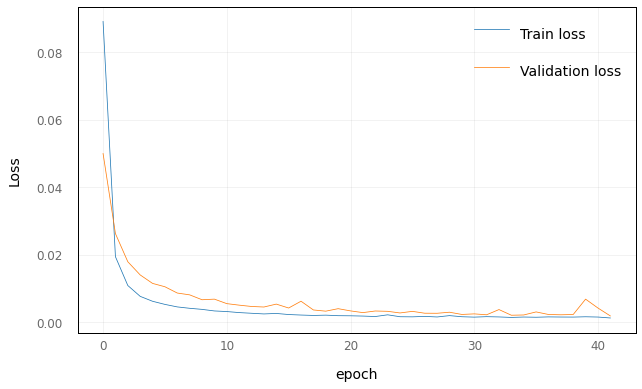

In [ ]:
model_history = scan_results.round_history[model_id]

# LOSS CURVE
# Plot train loss and validation loss
def plot_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
    plt.savefig('Loss curve.png', dpi=1200)
    # plt.show()

plot_loss(model_history)

In [ ]:
model_history['loss'][-1]

0.0012261765077710152

In [ ]:
model_history['val_loss'][-1]

0.0018312270985916257

In [ ]:
def save_best_model(scan_results, model_id, model_name):
    # Clear any previous TensorFlow session.
    tf.keras.backend.clear_session()


    # Load the model parameters from the scanner.
    model = tf.keras.models.model_from_json(scan_results.saved_models[model_id])
    model.set_weights(scan_results.saved_weights[model_id])
    model.summary()
    model.save('./best_model_' + model_name)
    return model


model = save_best_model(scan_results, model_id, 'rnn')


# Code to load that model
# my_tf_saved_model = tf.keras.models.load_model('./saved_models/my_tf_model')
# my_tf_saved_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 1)                 8         
                                                                 
 dropout (Dropout)           (None, 1)                 0         
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Assets written to: ./best_model_rnn/assets


In [ ]:
def plot_model_summary(model, model_name):
    plot_model(model, to_file='model_summary_' + model_name + '.png', show_shapes=True)

# Change function according to the model tuned
plot_model_summary(model, 'rnn')
# plot_model_summary(model, 'gru')
# plot_model_summary(model, 'lstm')
# plot_model_summary(model, 'cnn1d')

In [ ]:
# Make prediction
def prediction(model):
    prediction = model.predict(X_test)
    return prediction


prediction_rnn = prediction(model)

In [ ]:
prediction_rnn[:, :] = scaler.inverse_transform(prediction_rnn[:, :])
y_train[:, :] = scaler.inverse_transform(y_train[:, :])
y_test[:, :] = scaler.inverse_transform(y_test[:, :])


In [ ]:
prediction_rnn

array([[ 83.19247],
       [ 85.5461 ],
       [ 83.25065],
       ...,
       [161.06075],
       [160.78755],
       [159.40561]], dtype=float32)

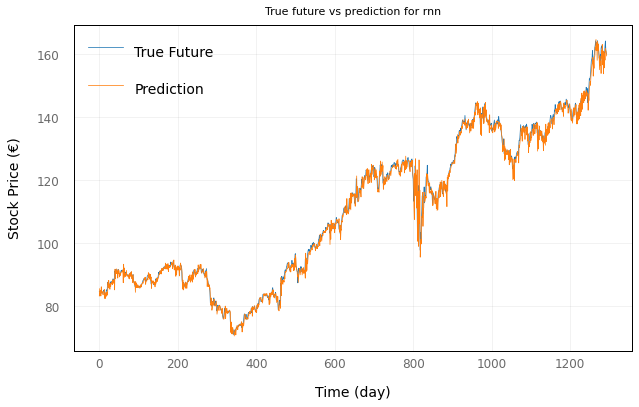

In [ ]:
def plot_future(prediction, model_name, y_test):
    plt.figure(figsize=(10, 6))
    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y_test), label='True Future')
    plt.plot(np.arange(range_future), np.array(prediction), label='Prediction')
    plt.title('True future vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Time (day)')
    plt.ylabel('Stock Price (€)')
    plt.savefig('Prediction_Evaluation_plot_' + model_name + '.png', dpi=1200)
    plt.show()


plot_future(prediction_rnn, 'rnn', y_test)

In [ ]:
# Define a function to calculate MAE and RSME
step_ahead=1

# Define a function to calculate MAE and RSME
def evaluate_prediction(predicted, actual, model_name):
    if step_ahead == 1:
        rsme = np.sqrt((mean_squared_error(predicted, actual)))
        mae = mean_absolute_error(actual, predicted)
        r2 = r2_score(actual, predicted)
        max_err = max_error(actual, predicted)
        print(model_name + ' performance:')
        print('R^2: {:.4f} %'.format(r2 * 100))
        print('Mean Absolute Error: {:.4f}'.format(mae))
        print('Root Mean Square Error: {:.4f}'.format(rsme))
        print('Max_error: {:.4f}'.format(max_err))
        print('')
        return
    else:
        titles = ["RMSE", "MAE", "R^2"]
        # calculate an RMSE score for each day
        # calculate mse
        rmse = np.sqrt(mean_squared_error(predicted, actual, multioutput='raw_values'))
        mae = mean_absolute_error(predicted, actual, multioutput='raw_values')
        r2 = r2_score(predicted, actual, multioutput='raw_values')
        df_scores = pd.DataFrame(list(zip(rmse, mae, r2)), columns=[f'{x}' for x in titles])
        df_scores.index += 1

        colors = plt.rcParams["axes.prop_cycle"]()
        a = 1  # number of rows
        b = 3  # number of columns
        c = 1  # initialize plot counter
        fig = plt.figure(figsize=(15, 6))
        for i in titles:
            plt.subplot(a, b, c)
            plt.title(f'{i}')
            next_colour = next(colors)["color"]
            df_scores[f'{i}'].plot(marker='o', color=next_colour)
            plt.xticks((range(0, df_scores.shape[0] + 1)))
            plt.legend(loc='upper left')
            plt.xlabel('Forecast Range (Day)')
            plt.ylabel(f'{i}')
            c = c + 1

        plt.subplots_adjust(.5)
        fig.suptitle("Evaluation of performances' trend in the multi step forecasted range", fontsize=16, y=1)
        plt.tight_layout()
        # plt.savefig('EvaluationMultiplePrediction_PG.png', dpi=1200)
        plt.show()

        # calculate overall RMSE
        overall_rmse = np.sqrt(mean_squared_error(predicted, actual, multioutput='uniform_average'))
        overall_mae = mean_absolute_error(predicted, actual, multioutput='uniform_average')
        overall_r2 = r2_score(predicted, actual, multioutput='uniform_average')
        print(model_name + ' performance:')
        print('R^2: {:.4f} %'.format(overall_r2 * 100))
        print('Mean Absolute Error: {:.4f}'.format(overall_mae))
        print('Root Mean Square Error: {:.4f}'.format(overall_rmse))
        print('')
        return


evaluate_prediction(prediction_rnn, y_test, 'rnn')

rnn performance:
R^2: 99.3034 %
Mean Absolute Error: 1.3305
Root Mean Square Error: 2.0010
Max_error: 19.2880

